In [1]:
%matplotlib inline

同样三步走：数据加载及预处理；模型构建；训练以及评测使用；

Data Path:/home/ly/pytorch_exercise/data/data-for-gene-names/;

# part1:读入以及准备数据;

In [151]:
from io import open
import os
import string
fileList=os.listdir('/home/ly/pytorch_exercise/data/data-for-classify-names')
for i in range(len(fileList)):
    fileList[i]=fileList[i].split('.')[0]
filepath='/home/ly/pytorch_exercise/data/data-for-classify-names/'
dic={}
#不同语言之间字符编码格式转换;
import unicodedata
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters)+1  # Plus EOS marker;  换一种表征方式(不可行,因为loss function的输入形式的要求);
                                                                                  #上一个任务根本不需要结束标志符啊!
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

for files in fileList:
    dic[files]=open(filepath+files+'.txt').read().strip().split('\n')
for files in fileList:
    for i in range(len(dic[files])):
        dic[files][i]=unicodeToAscii(dic[files][i])

In [152]:
import torch
def wordToTensor(s):
    temp=torch.zeros(len(s),1,n_letters)
    for i in range(len(s)):
        for j in range(n_letters):
            if all_letters[j]==s[i]:
                temp[i][0][j]=1
                break
    return temp
def targetToTensor(s):
    temp=torch.zeros(len(s),1,1)
    for i in range(1,len(s)):
        for j in range(n_letters):
            if all_letters[j]==s[i-1]:
                temp[i-1][0][0]=j
                break
    temp[i][0][0]=58
    return temp
def categoryToTensor(n):
    temp=torch.zeros(18)
    temp[n-1]=1
    return temp

In [153]:
from copy import deepcopy
dicTensor=deepcopy(dic)
targetTensor=deepcopy(dic)
for i in range(len(dic.keys())):
    for j in range(len(dic[dic.keys()[i]])):
        dicTensor[dic.keys()[i]][j]=wordToTensor(dic[dic.keys()[i]][j])
        targetTensor[dic.keys()[i]][j]=targetToTensor(dic[dic.keys()[i]][j])

In [118]:
#一个单词是一个训练样本;
#关于训练数据表征方面,向量长度相较上一个任务应该增加一个长度,因为要表征<EOS>结束符;
#也可以不增加长度,把<EOS>表征为全0向量即可;

# part2:定义网络结构;

In [154]:
import torch.nn as nn
from torch.autograd import Variable
class RNN(nn.Module):
    def __init__(self,category_size,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        self.hidden_size=hidden_size
        self.i2h=nn.Linear(category_size+input_size+hidden_size,hidden_size)
        self.i2o=nn.Linear(category_size+input_size+hidden_size,output_size)
        self.o2o=nn.Linear(hidden_size+output_size,output_size)
        self.dropout=nn.Dropout(0.5)
        self.softmax=nn.LogSoftmax()
    def forward(self,categoryTensor,inputTensor,hiddenTensor):
        input_combined1=torch.cat((categoryTensor,inputTensor),1)
        #cat不能同时cat三个!!
        input_combined=torch.cat((input_combined1,hiddenTensor),1)
        hidden=self.i2h(input_combined)
        output=self.i2o(input_combined)
        output_combined=torch.cat((hidden,output),1)
        output=self.o2o(output_combined)
        output=self.dropout(output)
        output=self.softmax(output)
        return output,hidden
    def initHidden(self):
        hidden=torch.zeros(1,self.hidden_size)
        return Variable(hidden)
n_hidden=128
n_categories=len(dic.keys())
rnn=RNN(n_categories,n_letters,n_hidden,n_letters)
criterion = nn.NLLLoss()

In [ ]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,C_size):   #将几个单元的output_size设置为同一长度;
        super(LSTM,self).__init__()
        self.hidden_size=hidden_szie
        self.C_size=C_size
        self.i2F=nn.Linear(input_size+hidden_size,1)
        self.i2I=nn.Linear(input_size+hidden_size,1)
        self.i2C=nn.Linear(input_size+hidden_size,output_size)
        self.i2O=nn.Linear(input_size+hidden_size,1)
    def forward(self,inputTensor,hiddenTensor,CTensor):
        input_combined=torch.cat((inputTensor,hiddenTensor),1)
        f=torch.sigmoid(self.i2F(input_combined))
        i=torch.sigmoid(self.i2I(input_combined))
        C_hat=torch.tanh(self.i2C(input_combined))
        #这点不对,torch里怎么进行广播机制,如何让一个数和一个矩阵相乘??
        CTensor_numpy=CTensor.numpy()
        C_hat_numpy=C_hat.numpy()
        f_numpy=f.numpy()
        i_numpy=i.numpy()
        CTensor=torch.from_numpy(f_numpy*CTensor_numpy+i_numpy*C_hat_numpy)
        #CTensor=f*CTensor+i*C_hat
        O=torch.sigmoid(self.i2O(input_combined,1))
        hiddenTensor=O*torch.tanh(C)
        return CTensor,hiddenTensor
    def initHidden(self):
        return Variable(torch.zeros(1,self.hidden_size))
    def initCTensor(self):
        return Variable(torch.zeros(1,self.C_size))

# part3:begin to train;

In [155]:
learning_rate=0.005
def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i][0].long())
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    return output, loss.data[0] / input_line_tensor.size()[0]
def category_one_hot(n):
    temp=torch.zeros(1,n_categories)
    for i in range(n_categories):
        if i==n:
            temp[0][i]=1
            break
    return temp

In [188]:
import time
import math
import random
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
n_iters=2000
plot_every=100
print_every=100
all_loss=[]
total_loss=0
start=time.time()
for iter in range(n_iters):
    n=random.randint(0,n_categories-1)
    m=random.randint(0,len(dic[dic.keys()[n]])-1)
    categoryTensor=Variable(category_one_hot(n))
    inputTensor=Variable(dicTensor[dic.keys()[n]][m])
    target=Variable(targetTensor[dic.keys()[n]][m])
    output,loss=train(categoryTensor,inputTensor,target)
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_loss.append(total_loss / plot_every)
        total_loss = 0

0m 0s (0 0%) 2.3721
0m 2s (100 0%) 3.7003
0m 3s (200 0%) 2.1352
0m 5s (300 0%) 2.3415
0m 6s (400 0%) 2.6146
0m 8s (500 0%) 3.6200
0m 9s (600 0%) 2.8616
0m 11s (700 0%) 2.7364
0m 13s (800 0%) 2.8849
0m 14s (900 0%) 2.6808
0m 16s (1000 0%) 3.7552
0m 24s (1100 0%) 2.6164
0m 30s (1200 0%) 2.5775
0m 36s (1300 0%) 2.3154
0m 42s (1400 0%) 2.5867
0m 48s (1500 0%) 1.5939
0m 54s (1600 0%) 2.1089
1m 0s (1700 0%) 2.1530
1m 6s (1800 0%) 2.8000
1m 11s (1900 0%) 1.9562


# part4:验证展示;

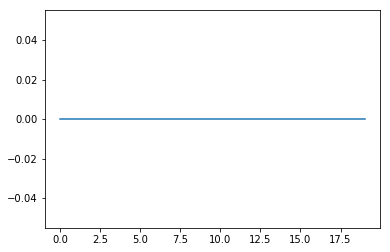

In [193]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.plot(all_loss)
plt.show()

use the model!

In [173]:
#给一个类别,一个首字符,进行字符串生成;下一时刻的输入是上一时刻的输出预测值;
max_len=30
def sample(category,start_letter):
    re=start_letter
    category_tensor=Variable(category_one_hot(category))
    start_tensor=Variable(wordToTensor(start_letter)[0])
    hidden=rnn.initHidden()
    for i in range(max_len):
        output,hidden=rnn(category_tensor,start_tensor,hidden)
        topv,topi=output.data.topk(1)
        topi=topi[0][0]
        if topi==n_letters-1:
            break
        else:
            re+=all_letters[topi]
        start_tensor=Variable(wordToTensor(all_letters[topi])[0])
    return re


In [192]:
s=sample(2,'e')
print s

None


over

In [ ]:
#调试代码,调出了一个bug:RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed. 
#出现这个bug的原因是网络结构中output_size弄错了!
hidden=rnn.initHidden()
category_tensor=Variable(category_one_hot(2))
input_tensor=Variable(wordToTensor(dic['Chinese'][0]))
output,hidden=rnn(category_tensor,input_tensor[0],hidden)
a1=Variable(torch.LongTensor([25]))
loss=criterion(output,a1)